In [1]:
import os
import esda
import pandas as pd
import geopandas as gpd
import libpysal as lps
import numpy as np
import matplotlib.pyplot as plt
import scipy
from splot.libpysal import plot_spatial_weights

In [2]:
data_path = os.path.join(os.getcwd(), 'Outputs', 'output.shp')
save_path = os.path.join(os.getcwd(), 'Outputs', 'Figures')

In [3]:
gdf = gpd.read_file(data_path)
# remove any coutnies that were outliers during PCA
nulls = gdf[gdf.isnull().any(axis=1)]
gdf = gdf.dropna()
print(gdf.shape)
print(nulls.shape)

(3100, 14)
(8, 14)


In [4]:
wq =  lps.weights.Queen.from_dataframe(gdf)

D:\Justin\Programs\Anaconda\envs\NSF_Research\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 1073.
  warnings.warn(message)


In [5]:
# Manual removal of islands from warning in the above cell
nulls = nulls.append(gdf.loc[1073] ,ignore_index=True)
gdf = gdf.drop(1073)
print(gdf.shape)
print(nulls.shape)

(3099, 14)
(9, 14)


In [6]:
wq =  lps.weights.Queen.from_dataframe(gdf)

D:\Justin\Programs\Anaconda\envs\NSF_Research\lib\site-packages\splot\_viz_libpysal_mpl.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_shp = gdf.centroid.values
D:\Justin\Programs\Anaconda\envs\NSF_Research\lib\site-packages\splot\_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid.plot(ax=ax, **node_kws)


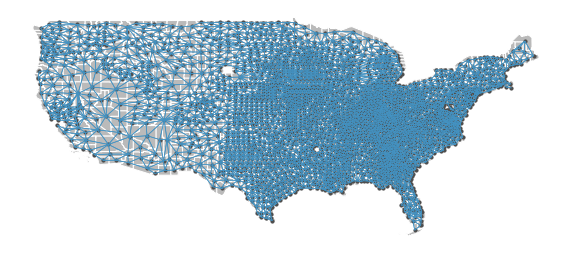

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_axis_off()
plot_spatial_weights(wq, gdf, ax=ax)
plt.show()

PC_1_Norm : 0.5562389429314257
Z-score : 52.42518689013671
Prob : 0.001


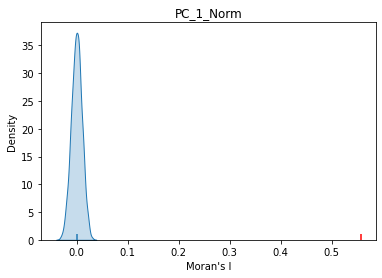

PC_2_Norm : 0.5441262049305395
Z-score : 51.284230699414366
Prob : 0.001


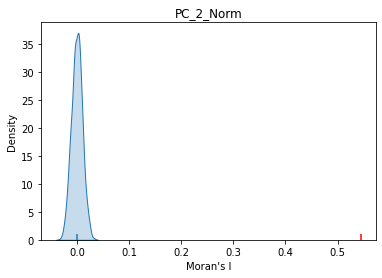

PC_3_Norm : 0.488505790169467
Z-score : 46.04508026558618
Prob : 0.001


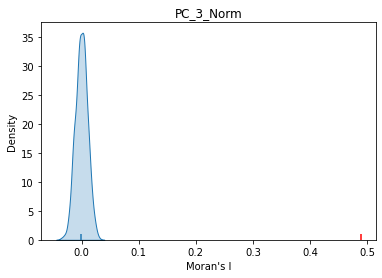

In [8]:
import seaborn as sbn
wq.transform = 'r'
for i in range(1,4):
    col = 'PC_{}_Norm'.format(i)
    y = gdf[col]
    mi = esda.moran.Moran(y, wq)
    print(col, ':',mi.I)
    print('Z-score :', mi.z_norm)
    print('Prob :', mi.p_sim)
    sbn.kdeplot(mi.sim, shade=True)
    plt.vlines(mi.I, 0, 1, color='r')
    plt.vlines(mi.EI, 0,1)
    plt.xlabel("Moran's I")
    plt.title(col)
    plt.show()

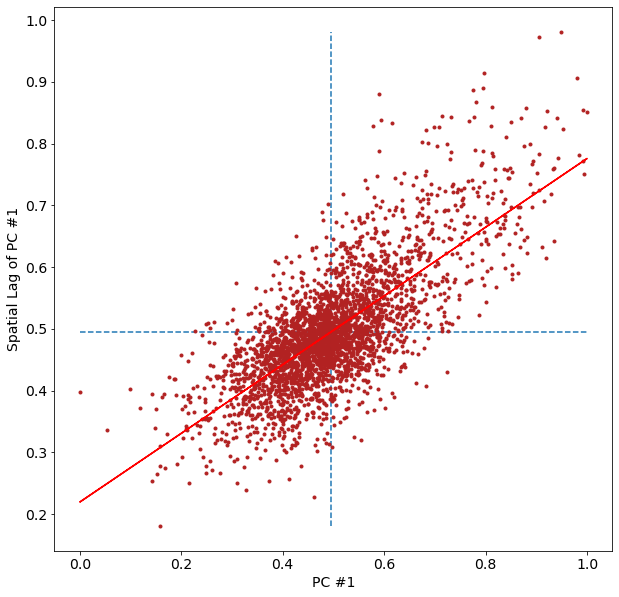

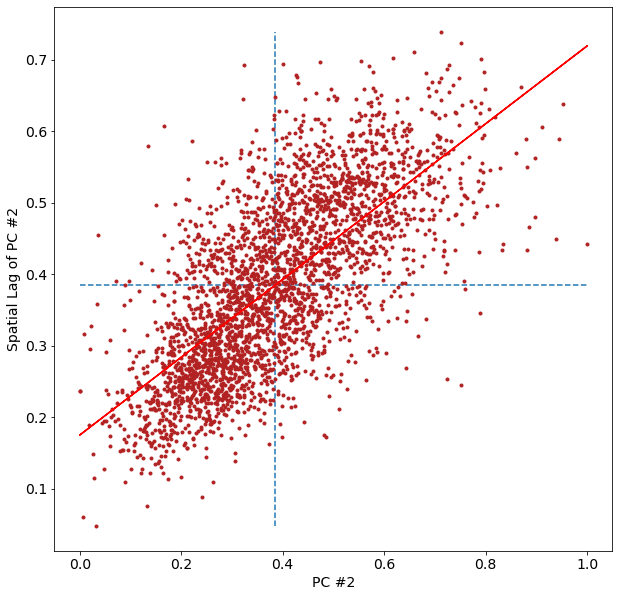

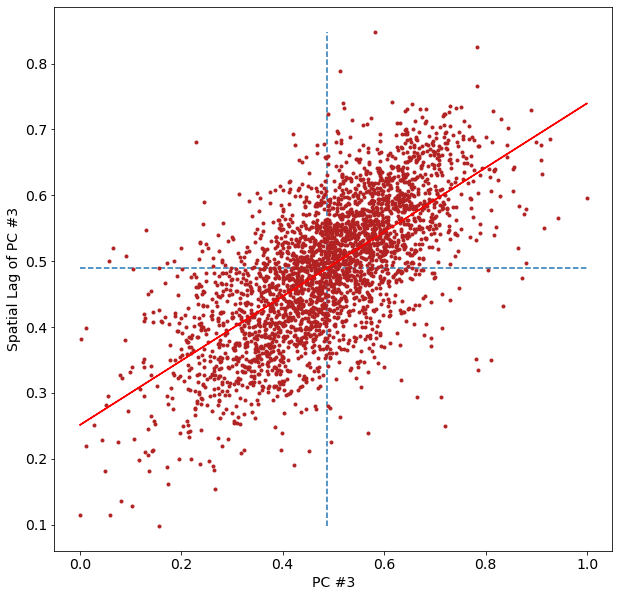

In [9]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
rcParams["legend.loc"] = 'lower right'
rcParams["font.size"] = 14

labels ={0:'ns', 1:'HH', 2:'LH', 3:'LL', 4:'HL'}
wq.transform = 'r'
for i in range(1,4):
    col = 'PC_{}_Norm'.format(i)
    y = gdf[col]
    lag = lps.weights.lag_spatial(wq, y)
    b, a = np.polyfit(y, lag, 1)
    f, ax = plt.subplots(1)

    plt.plot(y, lag, '.', color='firebrick')

     # dashed vert at mean 
    plt.vlines(y.mean(), lag.min(), lag.max(), linestyle='--')
     # dashed horizontal at mean of lagged 
    plt.hlines(lag.mean(), y.min(), y.max(), linestyle='--')

    # red line of best fit using global I as slope
    plt.plot(y, a + b*y, 'r')
#     plt.title('Moran Scatterplot')
    plt.ylabel('Spatial Lag of {} #{}'.format(*col.split('_')[0:2]), fontsize=14)
    plt.xlabel('{} #{}'.format(*col.split('_')[0:2]), fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig(os.path.join(save_path, 'LISA {} #{}.pdf'.format(*col.split('_')[0:2])))
    
    li = esda.moran.Moran_Local(y, wq)
#     print(len(li.q[li.p_sim < 0.05]))
    
    sig = 1 * (li.p_sim < 0.05)
    hotspot = 1 * (sig * li.q==1)
    coldspot = 3 * (sig * li.q==3)
    doughnut = 2 * (sig * li.q==2)
    diamond = 4 * (sig * li.q==4)
    
    spots = hotspot + coldspot + doughnut + diamond
    
    gdf['Local_{}'.format(i)] = [labels[i] for i in spots]
    
    

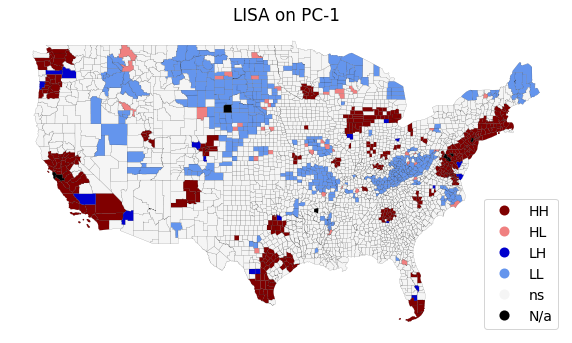

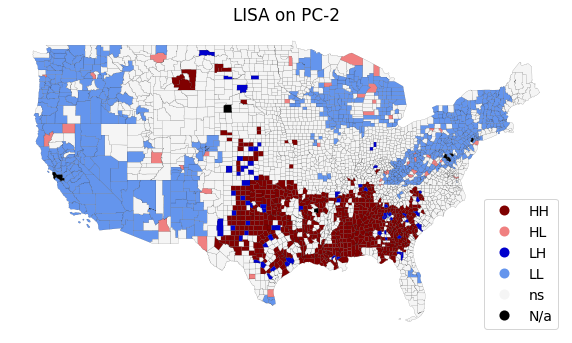

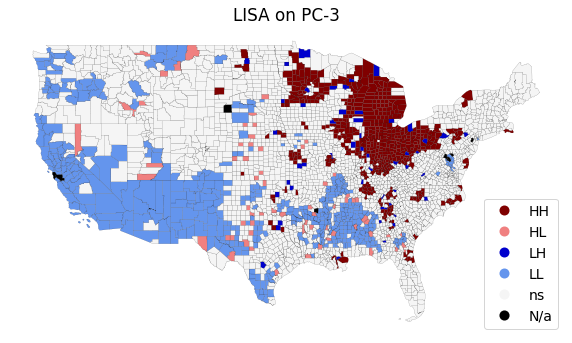

In [10]:
rdf = gpd.GeoDataFrame(pd.concat([gdf, nulls], ignore_index=True), crs=gdf.crs)
from matplotlib import colors
hmap = colors.ListedColormap([ 'maroon', 'lightcoral', 'mediumblue', 'cornflowerblue','whitesmoke'])


for i in range(1,4):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_axis_off()
    rdf.plot(ax=ax, column='Local_{}'.format(i), categorical=True,linewidth=0.1,edgecolor='black', cmap=hmap, legend=True, missing_kwds={'color': 'black', 'label':'N/a'}, legend_kwds={'loc': 'lower right'})
    ax.set_title('LISA on PC-{}'.format(i))
    plt.show()

In [11]:
rdf.to_file(os.path.join(os.getcwd(), 'Outputs', 'Output.shp'))

In [33]:
for c in [ 'maroon', 'lightcoral', 'mediumblue', 'cornflowerblue','whitesmoke']:
    print()
    for _c in colors.to_rgba(c):
        print(int(_c * 255), end=' ')


128 0 0 255 
240 128 128 255 
0 0 205 255 
100 149 237 255 
245 245 245 255 